# <div align="center">Data Science with Stock Data - Linear Models</div>
### <div align="center">Author: <a href="https://www.linkedin.com/in/kaming-yip-22b03a1a0/">Kaming Yip</a>&emsp;&emsp;Date: Mar. 4, 2020</div>

Before start reading this file, you are suggested to read the project instruction in the <a href="https://github.com/KamingYip/Data-Science-with-Stock-Data/blob/master/README.md">README.md</a> file.

In this file, we will implement and compare three <b>polynomial functions</b> (line-degree d = 1, quadratic-degree d = 2, and cubic-degree d = 3) for predicting next week labels based on the previous <i>W</i> weekly closing prices. Recall that a weekly closing price for week <i>i</i> is the adjusted closing price <i>P<sub>i</sub></i> for the last trading day of that week.

Assume that we are given <i>W</i> and we have weekly closing prices <i>P<sub>i</sub> , ... , P<sub>W</sub></i> for weeks <i>1, ... , W</i>. We want to predict a label ("red" or "green") for week <i>W + 1</i> using a polynomial model of degree <i>d</i> fitted on prices <i>P<sub>i</sub> , ... , P<sub>W</sub></i>.

We will proceed as follows. Construct a polynomial model of degree <i>d</i> to fit <i>P<sub>i</sub> , ... , P<sub>W</sub></i> and use this model to predict price <i>P<sup>*</sup><sub>W + 1</sub></i> for week <i>W + 1</i>. Then assign a label to week <i>W + 1</i> absed on the following three cases:

1. <i>P<sup>*</sup><sub>W + 1</sub></i> > <i>P<sub>W</sub></i> : week <i>W + 1</i> is assigned a "green" color (next week closing price is predicted to be higher than the current price, and therefore, we want to be invested)
2. <i>P<sup>*</sup><sub>W + 1</sub></i> < <i>P<sub>W</sub></i> : week <i>W + 1</i> is assigned a "red" color (next week closing price is predicted to be lower than the current price, and therefore, we want to remain in cash)
3. <i>P<sup>*</sup><sub>W + 1</sub></i> = <i>P<sub>W</sub></i> : week <i>W + 1</i> is assigned the same color as week <i>W</i>

First, we scrape the historical data from <a href="https://finance.yahoo.com/quote/YELP?p=YELP&.tsrc=fin-srch-v1">yahoo web</a> and manipulate the data to create desirable columns.

In [1]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np

In [2]:
def get_stock(ticker, start_date, end_date):
    try:
        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Return'] = 100.0 * df['Return']
        df['Return'] = df['Return'].round(3)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.weekday_name  
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 'Week_Number', 'Year_Week',
                    'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Return']
        df = df[col_list]
        return df
    except Exception as error:
        print(error)
        return None

ticker='YELP'
df = get_stock(ticker, start_date='2017-01-01', end_date='2019-12-31')
df.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return
Date,,,,,,,,,,,,,,
2017-01-03,2017-01-03,2017,1,3,Tuesday,01,2017-01,38.50,39.14,37.56,38.22,2391900,38.22,0.000
2017-01-04,2017-01-04,2017,1,4,Wednesday,01,2017-01,38.28,39.44,38.28,39.42,2238000,39.42,3.140
2017-01-05,2017-01-05,2017,1,5,Thursday,01,2017-01,39.20,40.18,38.81,39.62,2310900,39.62,0.507
2017-01-06,2017-01-06,2017,1,6,Friday,01,2017-01,39.80,39.96,39.21,39.31,1230200,39.31,-0.782
2017-01-09,2017-01-09,2017,1,9,Monday,02,2017-02,39.49,40.41,39.31,40.14,1719000,40.14,2.111


Then we will create the mean return and volatility values for each week. These two features will be our main independent variables to train the model.

In [3]:
def weekly_return_volatility(data, start_date, end_date):
    df_2 = data[data['Date'] >= start_date]
    df_2 = df_2[df_2['Date'] <= end_date]
    df_2 = df_2[['Year', 'Week_Number', 'Open', 'Adj Close', 'Return']]
    df_2.index = range(len(df_2))
    df_grouped = df_2.groupby(['Year', 'Week_Number'])['Return'].agg([np.mean, np.std])
    df_grouped.reset_index(['Year', 'Week_Number'], inplace=True)
    df_grouped.rename(columns={'mean': 'mean_return', 'std':'volatility'}, inplace=True)
    df_grouped.fillna(0, inplace=True)
    df_grouped["Open"] = df_2.groupby(["Year", "Week_Number"])["Open"].head(1).\
                                      reset_index(drop = True).copy()
    df_grouped["Adj Close"] = df_2.groupby(["Year", "Week_Number"])["Adj Close"].tail(1).\
                                           reset_index(drop = True).copy()
    return df_grouped

df_weekly = weekly_return_volatility(df, start_date='2018-01-01', end_date='2019-12-31')
df_weekly.head()

,Year,Week_Number,mean_return,volatility,Open,Adj Close
0,2018,00,0.7235,1.677695,42.06,43.17
1,2018,01,1.0174,1.548486,43.03,45.39
2,2018,02,-1.4135,2.049766,45.39,42.85
3,2018,03,0.6000,1.871186,42.70,44.12
4,2018,04,0.3262,2.706359,44.06,44.78


For each week, we will label as "green" or "red":
* a "green" week means that it was a good week to be invested for that week (from Friday to Friday)
* a "red" week means that it was <b>NOT</b> a good week (e.g. prices fell or there was too much volatility in the price)

In this project, we will label those weeks with mean return higher than or equal to the 50-percentile threshold as well as with volatility not higher than the 50-percentile threshold of that year as "Green"; otherwise, they will be labeled as "Red".

In [4]:
def weekly_label(data, year):
    df_label = data[data["Year"] == year].copy()
    mean_return_percent50 = np.percentile(df_label["mean_return"], 50)
    volatility_percent50 = np.percentile(df_label["volatility"], 50)      
    df_label["True Label"] = np.where((df_label["mean_return"] >= mean_return_percent50) & \
                                      (df_label["volatility"] <= volatility_percent50), "Green", "Red")
    return df_label

df_labeling = pd.DataFrame()
for year in [2018, 2019]:
    df_year_label = weekly_label(df_weekly, year)
    label_count = df_year_label.groupby("True Label")["True Label"].size().to_frame(name = "Freq")       
    df_labeling = df_labeling.append(df_year_label, ignore_index = True)
df_labeling["Week_Number"] = df_labeling["Week_Number"].astype(int)
df_labeling.head()

,Year,Week_Number,mean_return,volatility,Open,Adj Close,True Label
0,2018,0,0.7235,1.677695,42.06,43.17,Green
1,2018,1,1.0174,1.548486,43.03,45.39,Green
2,2018,2,-1.4135,2.049766,45.39,42.85,Red
3,2018,3,0.6000,1.871186,42.70,44.12,Red
4,2018,4,0.3262,2.706359,44.06,44.78,Red


Let's take a look at the label distribution in training data and testing data.

In [5]:
train_df = df_labeling[df_labeling["Year"] == 2018].copy()
test_df = df_labeling[df_labeling["Year"] == 2019].copy()

train_test_sum = pd.DataFrame({
    "Dataset": ["Training", "Testing", "Total"],
    "Week Num": ["{0:,}({1:.2f}%)".format(len(train_df), len(train_df)/len(df_labeling)*100),
                 "{0:,}({1:.2f}%)".format(len(test_df), len(test_df)/len(df_labeling)*100),
                 "{0:,}({1:.2f}%)".format(len(df_labeling), len(df_labeling)/len(df_labeling)*100)],
    "Green Label": ["{0:,}({1:.2f}%)".format(len(train_df[train_df["True Label"] == "Green"]),
                                             len(train_df[train_df["True Label"] == "Green"])/len(train_df)*100),
                    "{0:,}({1:.2f}%)".format(len(test_df[test_df["True Label"] == "Green"]),
                                             len(test_df[test_df["True Label"] == "Green"])/len(test_df)*100),
                    "{0:,}({1:.2f}%)".format(len(df_labeling[df_labeling["True Label"] == "Green"]),
                                             len(df_labeling[df_labeling["True Label"] == "Green"])/len(df_labeling)*100)],
    "Red Label": ["{0:,}({1:.2f}%)".format(len(train_df[train_df["True Label"] == "Red"]),
                                           len(train_df[train_df["True Label"] == "Red"])/len(train_df)*100),
                  "{0:,}({1:.2f}%)".format(len(test_df[test_df["True Label"] == "Red"]),
                                           len(test_df[test_df["True Label"] == "Red"])/len(test_df)*100),
                  "{0:,}({1:.2f}%)".format(len(df_labeling[df_labeling["True Label"] == "Red"]),
                                           len(df_labeling[df_labeling["True Label"] == "Red"])/len(df_labeling)*100)]})

train_test_sum

,Dataset,Week Num,Green Label,Red Label
0,Training,53(50.00%),16(30.19%),37(69.81%)
1,Testing,53(50.00%),14(26.42%),39(73.58%)
2,Total,106(100.00%),30(28.30%),76(71.70%)


By far, we have completed the data preparation. From the raw data, we have conducted feature engineering to create new features that we would use in the modeling, calculated the average return and volatility for each week, and labeled each week as "Green" or "Red" by a predetermined rule. We will then use the labeled dataset in the following sections.

We will first define our confusion matrix function to better visualize the model performance, including Accuracy, Recall, Precision, and F1 score.

In [6]:
from tabulate import tabulate
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [7]:
def designed_confusion_matrix(train_actual, train_pred, train_title,
                              test_actual, test_pred, test_title,
                              classes, sup_title):
    fig = plt.figure(figsize = (8, 5))
    fig.suptitle(sup_title, fontweight = "bold")
            
    fig.add_subplot(221)
    train_cm = confusion_matrix(train_actual, train_pred)
    plt.imshow(train_cm, interpolation = "nearest", cmap = "Reds")
    plt.title(train_title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(train_cm.shape[0]), range(train_cm.shape[1])):
        plt.text(j, i, format(train_cm[i, j], "d"), horizontalalignment = "center", color = "black")
    plt.tight_layout()
    plt.ylabel("Actual Class")      
    plt.xlabel("Predicted Class")
            
    fig.add_subplot(222)
    test_cm = confusion_matrix(test_actual, test_pred)
    plt.imshow(test_cm, interpolation = "nearest", cmap = "Reds")
    plt.title(test_title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(test_cm.shape[0]), range(test_cm.shape[1])):
        plt.text(j, i, format(test_cm[i, j], "d"), horizontalalignment = "center", color = "black")
    plt.tight_layout()
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")
    
    fig.subplots_adjust(top = 0.85)
    plt.show()
    
    stats_summary = pd.DataFrame(columns = ["Training Data", "Testing Data"],
                                 index = ["Accuracy", "Recall", "Precision", "F1 Score"])
    stats_set = [[train_actual, train_pred], [test_actual, test_pred]]
    for i, ele in enumerate(stats_set):
        stats_summary.iloc[:, i] = [accuracy_score(ele[0], ele[1]),
                                    recall_score(ele[0], ele[1], pos_label = classes[0]),
                                    precision_score(ele[0], ele[1], pos_label = classes[0]),
                                    f1_score(ele[0], ele[1], pos_label = classes[0])]
    print(tabulate(stats_summary, headers = "keys", numalign = "right", floatfmt = ".3f"), end = "\n\n")

We will take weekly data for year 2018 and for each window size <i>W</i> = 5,6, ... ,12 and for each degree <i>d</i> = 1,2,3 construct the corresponding polynomials. By applying these polynomials, we then predict weekly labels for year 2018 and plot the accuracy plot - on <i>x</i> axis we have <i>W</i> and plot three curves for accuracy (separate curve for each degree <i>d</i>).

In [8]:
def polynomial_fit(data, W, d):
    """
    to fit the W weekly closing prices with a polynomial model
    and predict the label for W+1 week
    """
    pred_labels = []
    prev_label = "None"
    for i in range(len(data) - W):
        x = data.iloc[i : (i + W)]["Week_Number"].values
        y = data.iloc[i : (i + W)]["Adj Close"].values
        weights = np.polyfit(x, y, d)
        model = np.poly1d(weights)
        x_new = data.iloc[i + W]["Week_Number"]
        y_pred = model(x_new)
        prev_price = data.iloc[i + W - 1]["Adj Close"]
        if y_pred > prev_price:
            pred_labels.append("Green")
            prev_label = "Green"
        elif y_pred < prev_price:
            pred_labels.append("Red")
            prev_label = "Red"
        else:
            if prev_label == "None":
                pred_labels.append(data.iloc[i + W - 1]["True Label"])
            else:
                pred_labels.append(prev_label)
    return np.asarray(pred_labels)

                         Accuracy Table for Training Data

         W = 5    W = 6    W = 7    W = 8    W = 9    W = 10    W = 11    W = 12
-----  -------  -------  -------  -------  -------  --------  --------  --------
d = 1    0.521    0.617    0.522    0.600    0.523     0.558     0.500     0.537
d = 2    0.521    0.489    0.478    0.533    0.659     0.605     0.690     0.634
d = 3    0.417    0.468    0.478    0.556    0.568     0.558     0.524     0.537



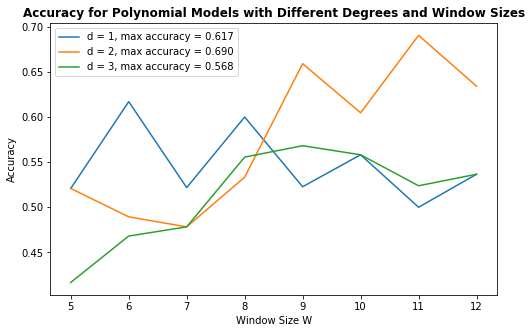

In [9]:
d_range = list(range(1, 4))
W_range = list(range(5, 13))
train_df = df_labeling.loc[df_labeling["Year"] == 2018].copy().reset_index(drop = True)
train_accuracy = pd.DataFrame(index = [("d = " + str(i)) for i in d_range],
                              columns = [("W = " + str(i)) for i in W_range])
for d in d_range:
    for W in W_range:
        true_labels = train_df.loc[W : , "True Label"].values
        pred_labels = polynomial_fit(train_df, W, d)
        train_accuracy.loc["d = " + str(d), "W = " + str(W)] = accuracy_score(true_labels, pred_labels)

print(" " * 25 + "Accuracy Table for Training Data",
      tabulate(train_accuracy, headers = "keys", numalign = "right", floatfmt = ".3f"), sep = "\n\n", end = "\n\n")

fig, ax = plt.subplots(figsize = (8, 5))
for d in d_range:
    d_label = "d = " + str(d)
    y = train_accuracy.loc[d_label].values
    ax.plot(W_range, y, label = d_label + ", max accuracy = {0:.3f}".format(y.max()))
ax.legend(loc = "upper left")
plt.title("Accuracy for Polynomial Models with Different Degrees and Window Sizes", fontweight = "bold")
plt.xticks(W_range)
plt.xlabel("Window Size W")
plt.ylabel("Accuracy")
plt.show()

As demonstrated in the curve plot, for each degree, the polynomial model performs differently against each other. To be more specific, the highest accuracy of line-degree (<i>d</i> = 1) model occurred when window size <i>W</i> = 6, while the best-performance window size is W = 11 in quadratic-degree (<i>d</i> = 2) model and W = 9 in cubic-degree (<i>d</i> = 3) model. As for the accuracy performance trend in each curve, the plot suggests that the accuracy generally decreases when the window size increases in line-degree model; on the contrary, the accuracy tends to increase in quadratic-degree model and cubic-degree model, respectively, as the window size increases.

Next, for each <i>d</i>, we will take the best <i>W</i> value that gives us the highest accuracy and use this W to predict labels for year 2019.

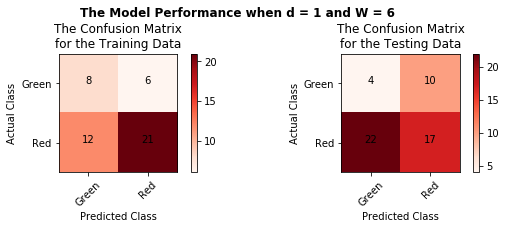

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             0.617           0.396
Recall               0.571           0.286
Precision            0.400           0.154
F1 Score             0.471           0.200



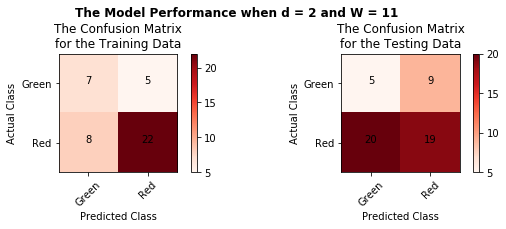

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             0.690           0.453
Recall               0.583           0.357
Precision            0.467           0.200
F1 Score             0.519           0.256



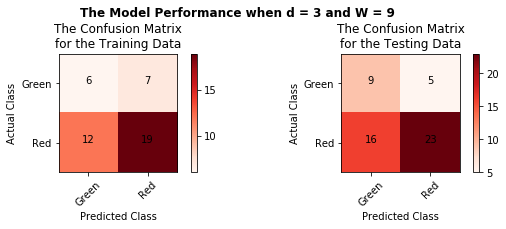

             Training Data    Testing Data
---------  ---------------  --------------
Accuracy             0.568           0.604
Recall               0.462           0.643
Precision            0.333           0.360
F1 Score             0.387           0.462



In [10]:
train_accuracy_copy = train_accuracy.copy().apply(pd.to_numeric)
train_accuracy_copy.columns = W_range
best_W = train_accuracy_copy.idxmax(axis = 1).tolist()

test_df = df_labeling[df_labeling["Year"] == 2019].copy().reset_index(drop = True)
pred_labels_all = pd.DataFrame(columns = [("W = " + str(i)) for i in best_W])

for i in range(len(d_range)):
    d = d_range[i]
    W = best_W[i]
    
    train_true_labels = train_df.loc[W : , "True Label"].values
    train_pred_labels = polynomial_fit(train_df, W, d)
    
    model_data = pd.concat([train_df[-W : ], test_df], axis = 0, ignore_index = True)
    test_true_labels = model_data.loc[W : , "True Label"].values
    test_pred_labels = polynomial_fit(model_data, W, d)
    pred_labels_all["W = " + str(W)] = test_pred_labels
    
    designed_confusion_matrix(train_true_labels, train_pred_labels, "The Confusion Matrix\nfor the Training Data",
                              test_true_labels, test_pred_labels, "The Confusion Matrix\nfor the Testing Data",
                              ["Green", "Red"], "The Model Performance when d = {0} and W = {1}".format(d, W))

By analyzing the confusion matrix, we learn that the linear models created by polynomial functions, no matter in which degree, perform poorly in predicting the labels. Even the cubic-degree (<i>d</i> = 3) linear model, which is the best evaluated by all the four listed metrics, can merely reach an accuracy of 60.4% and a F1 score as 0.462. The results indicate that the stock price was not linearly distributed so that it can not be effeciently predicted by linear model.

Anyhow, we will implement the trading strategy suggested by each model and test how they actually perform in trading stock.

In [11]:
def trade_with_labels(data, col_name):
    money = 100.0
    shares = 0.0
    position = "No"
    balance = []
    df_trade_labels = data.copy()
    for i in range(len(df_trade_labels) - 1):
        if i == 0:
            label = df_trade_labels.iloc[i][col_name]
            if label == "Green":
                shares = money / df_trade_labels.iloc[i]["Open"]
                money = 0.0
                position = "Long"
                balance.append(shares * df_trade_labels.iloc[i]["Adj Close"])
            else:
                balance.append(money)              
        else:
            label = df_trade_labels.iloc[i+1][col_name]
            if label == "Red":
                if position == "Long":
                    money = shares * df_trade_labels.iloc[i]["Adj Close"]
                    shares = 0.0
                    position = "No"
                balance.append(money)
            else:
                if position == "No":
                    shares = money / df_trade_labels.iloc[i+1]["Open"]
                    money = 0.0
                    position = "Long"
                balance.append(shares * df_trade_labels.iloc[i]["Adj Close"])            
    if position == "Long":
        balance.append(shares * df_trade_labels.iloc[-1]["Adj Close"])
    else:
        balance.append(money)
    return balance

def script_text(data, year, col_name):
    label_text_final = "{0} Final:\n${1}".format(year, round(data[data["Year"] == year].iloc[-1][col_name], 2))
    label_x_final = data[data["Year"] == year].tail(1).index.values
    label_y_final = round(data[data["Year"] == year].iloc[-1][col_name], 2)
    return label_text_final, label_x_final, label_y_final

def buy_n_hold(data):
    money = 100.0
    shares = 0.0
    balance = []
    df_buy_hold = data.copy()  
    for i in range(len(df_buy_hold)):
        if i == 0:
            shares = money / df_buy_hold.iloc[i]["Open"]
        balance.append(shares * df_buy_hold.iloc[i]["Adj Close"])
    return balance

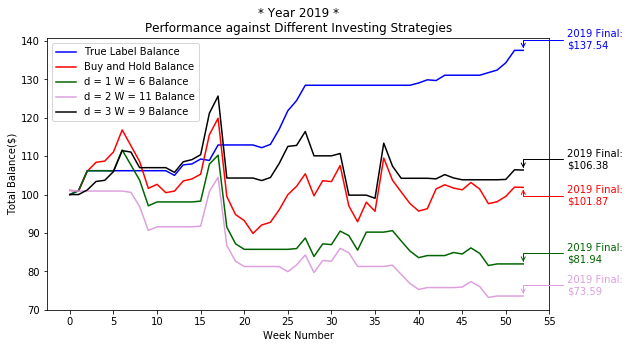

In [12]:
df_trading = df_labeling[df_labeling["Year"] == 2019].copy().reset_index(drop = True)
df_trading["True Label Balance"] = trade_with_labels(df_trading, "True Label")
df_trading["Buy and Hold Balance"] = buy_n_hold(df_trading)

for i in range(len(d_range)):
    d = d_range[i]
    W = best_W[i]
    df_trading["d = {0} W = {1} Label".format(d, W)] = pred_labels_all["W = {0}".format(W)]
    df_trading["d = {0} W = {1} Balance".format(d, W)] =\
        trade_with_labels(df_trading, "d = {0} W = {1} Label".format(d, W))
    
label_text_final_2019, label_x_final_2019, label_y_final_2019 =\
    script_text(df_trading, 2019, "True Label Balance")
buy_hold_text_final_2019, buy_hold_x_final_2019, buy_hold_y_final_2019 =\
    script_text(df_trading, 2019, "Buy and Hold Balance")
d1_text_final_2019, d1_x_final_2019, d1_y_final_2019 = script_text(df_trading, 2019, "d = 1 W = 6 Balance")
d2_text_final_2019, d2_x_final_2019, d2_y_final_2019 = script_text(df_trading, 2019, "d = 2 W = 11 Balance")
d3_text_final_2019, d3_x_final_2019, d3_y_final_2019 = script_text(df_trading, 2019, "d = 3 W = 9 Balance")

fig, ax = plt.subplots(figsize = (9, 5))

# Trading with True Label
ax.plot(df_trading.index, "True Label Balance", data = df_trading, color = "blue")
        
ax.annotate(label_text_final_2019, xy = (label_x_final_2019, label_y_final_2019), xycoords = "data",
            xytext = (label_x_final_2019+5, label_y_final_2019), color = "blue",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "blue"),
            ha = "left", va = "bottom")
        
# Buy and Hold
ax.plot(df_trading.index, "Buy and Hold Balance", data = df_trading, color = "red")
        
ax.annotate(buy_hold_text_final_2019, xy = (buy_hold_x_final_2019, buy_hold_y_final_2019), xycoords = "data",
            xytext = (buy_hold_x_final_2019+5, buy_hold_y_final_2019-5), color = "red",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "red"),
            ha = "left", va = "bottom")
        
# Trading with d = 1 W = 6 Label
ax.plot(df_trading.index, "d = 1 W = 6 Balance", data = df_trading, color = "darkgreen")
        
ax.annotate(d1_text_final_2019, xy = (d1_x_final_2019, d1_y_final_2019), xycoords = "data",
            xytext = (d1_x_final_2019+5, d1_y_final_2019), color = "darkgreen",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "darkgreen"),
            ha = "left", va = "bottom")
        
# Trading with d = 2 W = 11 Label
ax.plot(df_trading.index, "d = 2 W = 11 Balance", data = df_trading, color = "plum")
        
ax.annotate(d2_text_final_2019, xy = (d2_x_final_2019, d2_y_final_2019), xycoords = "data",
            xytext = (d2_x_final_2019+5, d2_y_final_2019), color = "plum",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "plum"),
            ha = "left", va = "bottom")
        
# Trading with d = 3 W = 9 Label
ax.plot(df_trading.index, "d = 3 W = 9 Balance", data = df_trading, color = "black")
        
ax.annotate(d3_text_final_2019, xy = (d3_x_final_2019, d3_y_final_2019), xycoords = "data",
            xytext = (d3_x_final_2019+5, d3_y_final_2019), color = "black",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "black"),
            ha = "left", va = "bottom")
        
plt.title("* Year 2019 *\n" + "Performance against Different Investing Strategies", loc = "center")
plt.xlabel("Week Number")
plt.xticks(np.arange(0, 60, 5))
plt.ylabel("Total Balance($)")
plt.legend()
plt.show()

Interestingly, the performance plot demonstrates that only the linear model built with cubic-degree (<i>d</i> = 3) polynomial functions outperform the buy-and-hold strategy, which is the "laziest" strategy, and none of those linear models can beat the trading strategy provided by the actual labels, which is unusual in this project. The cubic-degree model barely earns $106.38 at the end of the year, and the other two linear models both suffer a deficit and fall short to the capital (i.e. $100 at the beginning of the year).

By comparing the curves, it is displayed that there are more balance fluctuations occurred in the strategies suggested by the linear models. Instead of making it more profitable like other machine learning models, these linear models did poorly not only in predicting the stock labels but also providing investment strategies.